In [309]:
import sys
sys.path.append('../')

import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
import matplotlib as mpl
from astropy.io import ascii as asc
from astropy.table import Table
from MACT_utils import composite_errors, get_tempz, get_mainseq_fit_params

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

In [310]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',
    guess=False, Reader=asc.FixedWidthTwoLine)
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & 
    (corr_tbl['stlr_mass'] >= CUTOFF_MASS))[0]
corr_tbl = corr_tbl[good_sig_iis]

filts = corr_tbl['filt'].data
sigmas = corr_tbl['meas_errs'].data
mass = corr_tbl['stlr_mass'].data
sfr = corr_tbl['met_dep_sfr'].data
dust_corr_factor = corr_tbl['dust_corr_factor'].data
filt_corr_factor = corr_tbl['filt_corr_factor'].data
nii_ha_corr_factor = corr_tbl['nii_ha_corr_factor'].data
sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

z_sp = corr_tbl['zspec0'].data
no_spectra  = np.where((z_sp <= 0) | (z_sp > 9))[0]
yes_spectra = np.where((z_sp > 0) & (z_sp < 9))[0]

tempz = get_tempz(z_sp, filts)
mz_data = np.vstack([mass, tempz]).T

N = len(good_sig_iis)

In [311]:
eqn0 = r'$\log(SFR) = \alpha \log(M) + \beta$'
def func0(data, a, b):
    return a*data + b

eqn1 = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func1(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

eqn2 = r'$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta$'
def func2(x, a1, a2, b):
    return np.piecewise(x, [x < m_char], [lambda x:a1*(x-m_char)+b, lambda x:a2*(x-m_char)+b])
    
eqn3 = r'$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta z + \gamma$'
def func3(x, a1, a2, b, c):
    m = x[:,0]
    z = x[:,1]
    return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])

eqnN = r'$\log(SFR) = S_0 - \log(1 + (\frac{10^M}{10^{M_0}})^{-\gamma}$'
def funcN(mass, gamma):
    return np.max(sfrs) - np.log10(1 + ((10**mass)/(10**8.))**(-gamma))

In [312]:
# m_char_arr = np.arange(7.1,10.1,0.1)
# for m_char in m_char_arr:
#     def funcN(mass, gamma):
#         return np.max(sfrs) - np.log10(1 + ((10**mass)/(10**m_char))**(-gamma))
#     params, pcov = optimize.curve_fit(funcN, mass, sfrs)
#     print params

## fitting without piecewise functions

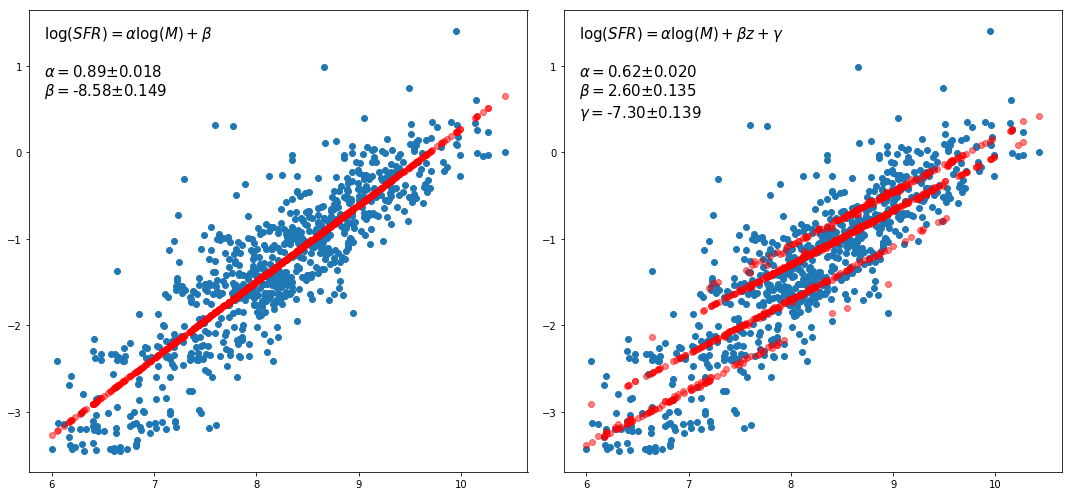

In [313]:
f, axes = plt.subplots(1,2)
# axarr = np.ndarray.flatten(axes)
f.set_size_inches(15,7)

for ax, func, eqn_str in zip(axes, [func0, func1], [eqn0, eqn1]):
    ax.plot(mass, sfrs, 'o')
    
    if 'gamma' not in eqn_str: # just a line w/o redshift dependence
        params, pcov = optimize.curve_fit(func, mass, sfrs)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
            '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1],
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # w/ redshift dependence
        params, pcov = optimize.curve_fit(func, mz_data, sfrs)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
            '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
            '\n'+r'$\gamma=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
            transform=ax.transAxes,fontsize=15,ha='left',va='top')


plt.tight_layout()
plt.show()

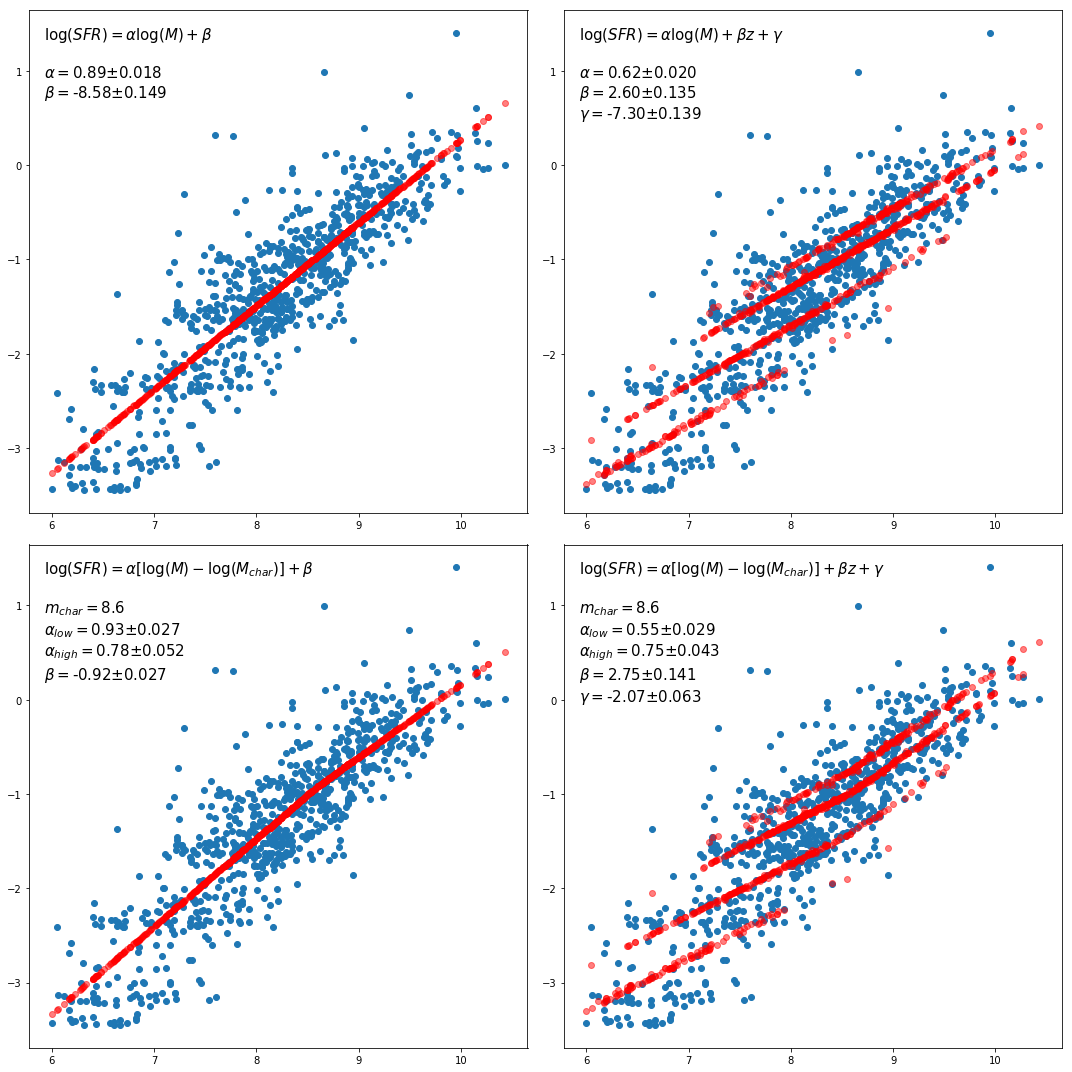

In [314]:
f, axes = plt.subplots(2,2)
axarr = np.ndarray.flatten(axes)
f.set_size_inches(15,15)

for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3], [eqn0, eqn1, eqn2, eqn3]):
    ax.plot(mass, sfrs, 'o')
    if 'char' not in eqn_str:
        if 'gamma' not in eqn_str: # just a line w/o redshift dependence
            params, pcov = optimize.curve_fit(func, mass, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
        else: # w/ redshift dependence
            params, pcov = optimize.curve_fit(func, mz_data, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\gamma=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        if 'gamma' not in eqn_str:
            m_char = 8.6 # 9.1
            params, pcov = optimize.curve_fit(func, mass, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$m_{char}=$'+str(m_char)+
                '\n'+r'$\alpha_{low}=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\alpha_{high}=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\beta=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
        else:
            m_char = 8.6
            params, pcov = optimize.curve_fit(func, mz_data, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$m_{char}=$'+str(m_char)+
                '\n'+r'$\alpha_{low}=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\alpha_{high}=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\beta=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2]+
                '\n'+r'$\gamma=$'+'%.2f'%params[3]+r'$\pm$'+'%.3f'%perr[3],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')

plt.tight_layout()
plt.show()

$$\log(SFR) = \alpha \log(M) + \beta$$

In [318]:
k = 2 # (a,b)
nu = N - k

# params, pcov = optimize.curve_fit(func0, mass, sfrs)
params_arr = get_mainseq_fit_params(sfrs, sigmas, mass, num_params=2)
params = [np.mean(params_arr[i]) for i in range(len(params_arr))]
a = params[0]
b = params[1]
print a,b

rss = np.sum( (sfrs - func0(mass, *params))**2 )  # residual sum of squares
tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
r2 = 1 - (rss / tss)    # r-squared
r2adj = 1.0 - (N - 1.0)/(N - k - 1.0) * (1 - r2)    # adjusted r-squared
rmse = np.std((sfrs - func0(mass, *params)))      # root mean square error
old_chi2 = np.sum( (func0(mass, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
chi2 = np.sum(((sfrs - func0(mass, *params))**2)/sigmas**2)

tt = Table([[a], [b], [r2], [r2adj], [rmse], [old_chi2], [old_chi2/nu], [chi2], [chi2/nu]], 
       names=['a', 'b', r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
              'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

0.8852109667227506 -8.576677833652782


a,b,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.8852109667227506,-8.576677833652782,0.7563908870500388,0.7557614061380233,0.43967822156225855,587.8883597125258,0.7585656254355172,172848.1644561107,223.02988962078803


In [319]:
np.mean((sfrs - func0(mass, *params))**2)

0.19331695121829492

777 777 777
222.4558101108246
31.829447268998198


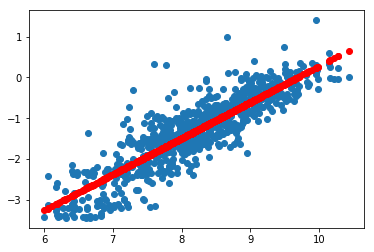

In [320]:
print len(sfrs), len(mass), len(sigmas)
resids = sfrs - func0(mass, *params)

print np.mean( (resids/sigmas)**2 )
print np.sum( ((10**resids)/(10**sigmas))**2 )/nu
# print nu
# print
# print np.sum( ((sfrs - func0(mass, *params))/sigmas)**2 )
# print np.sum( ((sfrs - func0(mass, *params))/sigmas)**2 )/nu

plt.plot(mass, sfrs, 'o')
plt.plot(mass, func0(mass, *params), 'ro')

In [321]:
# https://arxiv.org/pdf/1012.3754.pdf
# The first and foremost thing to do in order to assess the goodness of fit of some model to some
# data is to inspect the residuals. This is indeed trivial, because the residuals have already been
# computed in order to evaluate χ2
# (cf. Eq. (1)). For the true model having the true parameter
# values and a-priori known measurement errors, the distribution of normalised residuals (cf. Eq.
# (13)) is by definition Gaussian with mean µ = 0 and variance σ2 = 1. For any other model, this
# is not true. Consequently, all one needs to do is to plot the distribution of normalised residuals
# in a histogram and compare it to a Gaussian of µ = 0 and σ2 = 1. If the histogram exhibits
# a statistically significant deviation from the Gaussian, we can rule out that the model is the
# truth. If there is no significant difference between histogram and Gaussian, this can mean (a)
# we found the truth, or (b) we do not have enough data points to discover the deviation. The
# comparison of the residuals to this Gaussian should be objectively quantified, e.g., by using a
# Kolmogorov-Smirnov test (Kolmogorov 1933; Smirnov 1948).

0.2750017144997732 0.3378852219643188


KstestResult(statistic=0.05523090467059544, pvalue=0.016806866304479477)

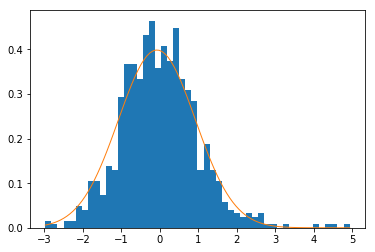

In [322]:
import scipy.stats as stats

resids = sfrs - func0(mass, *params)
print np.median(abs(resids)), np.mean(abs(resids))
std_resids = resids/np.std(resids) # standardized/normalized residuals
histfreqs = np.histogram(std_resids, bins=50)
freqs = np.column_stack((histfreqs[0], histfreqs[1][:-1]))
data = np.hstack([np.repeat(x,int(f)) for f,x in freqs])

loc, scale = stats.norm.fit(data)
n = stats.norm(loc=loc, scale=scale)

plt.hist(std_resids, bins=50, density=True)
x = np.linspace(std_resids.min(), std_resids.max(), 100)
plt.plot(x, n.pdf(x))
stats.kstest(data, n.cdf)
# smaller p value indicates more significantly the null hypothesis is to be rejected

In [324]:
# histfreqs = np.histogram(std_resids, bins=50)
# freqs = np.column_stack((histfreqs[0], histfreqs[1][:-1]))
# data = np.hstack([np.repeat(x,int(f)) for f,x in freqs])

# loc, scale = stats.norm.fit(data)
# n = stats.norm(loc=loc, scale=scale)

# plt.hist(std_resids, bins=50, density=True)
# x = np.linspace(std_resids.min(), std_resids.max(), 100)
# plt.plot(x, n.pdf(x))
# stats.kstest(data, n.cdf)
# smaller p value indicates more significantly the null hypothesis is to be rejected

$$\log(SFR) = \alpha \log(M) + \beta z + \gamma$$

In [326]:
k = 3 # (a,b,c)
nu = N - k

In [328]:
params, pcov = optimize.curve_fit(func1, mz_data, sfrs)
a = params[0]
b = params[1]
c = params[2]

rss = np.sum( (sfrs - func1(mz_data, *params))**2 )  # residual sum of squares
tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
r2 = 1 - (rss / tss)    # r-squared
r2adj = 1.0 - (N - 1.0)/(N - k - 1.0) * (1 - r2)    # adjusted r-squared
rmse = np.std((sfrs - func1(mz_data, *params)))      # root mean square error
old_chi2 = np.sum( (func1(mz_data, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
chi2 = np.sum(((sfrs - func1(mz_data, *params))**2)/sigmas**2)

tt = Table([[a], [b], [c], [r2], [r2adj], [rmse], [old_chi2], [old_chi2/nu], [chi2], [chi2/nu]], 
       names=['a', 'b', 'c', r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
              'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

a,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.6208112541082348,2.5990655033813526,-7.2970727846104895,0.8353696783183805,0.83473075080862,0.36144574527066936,649.0822427551583,0.8386075487792742,212547.12748361027,274.60869183928975


0.2257815725854897 0.27482712285915206


KstestResult(statistic=0.07894333927123942, pvalue=0.00011682160783643349)

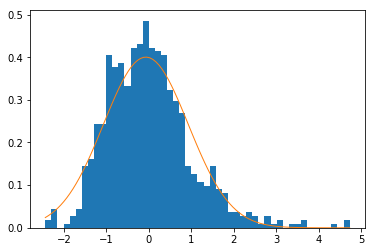

In [329]:
resids = sfrs - func1(mz_data, *params)
print np.median(abs(resids)), np.mean(abs(resids))
std_resids = resids/np.std(resids) # standardized/normalized residuals
histfreqs = np.histogram(std_resids, bins=50)
freqs = np.column_stack((histfreqs[0], histfreqs[1][:-1]))
data = np.hstack([np.repeat(x,int(f)) for f,x in freqs])

loc, scale = stats.norm.fit(data)
n = stats.norm(loc=loc, scale=scale)

plt.hist(std_resids, bins=50, density=True)
x = np.linspace(std_resids.min(), std_resids.max(), 100)
plt.plot(x, n.pdf(x))
stats.kstest(data, n.cdf)
# smaller p value indicates more significantly the null hypothesis is to be rejected

## fitting with a piecewise powerlaw fit (no redshift dependence)

$$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta$$

In [331]:
# k = 3 # (a1,a2,b)
# nu = N - k

In [330]:
# a_low_arr, a_high_arr, b_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[]
# m_char_arr = np.arange(8.0,10.1,0.1)

# for m_char in m_char_arr:
#     def piecewise_linear(x, a1, a2, b):
#         return np.piecewise(x, [x < m_char], [lambda x:a1*(x-m_char)+b, lambda x:a2*(x-m_char)+b])
    
#     params, pcov = optimize.curve_fit(piecewise_linear, mass, sfrs)
#     a1 = params[0]
#     a2 = params[1]
#     b = params[2]

#     a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
#     a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
#     b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    
#     rss = np.sum( (sfrs - piecewise_linear(mass, *params))**2 )  # residual sum of squares
#     tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
#     r2 = 1 - (rss / tss)    # r-squared
#     r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
#     rmse = np.std((sfrs - piecewise_linear(mass, *params)))      # root mean square error
#     old_chi2 = np.sum( (piecewise_linear(mass, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
#     chi2 = np.sum(((sfrs - piecewise_linear(mass, *params))**2)/sigmas**2)

#     r2_arr.append(np.around(r2,6))
#     r2adj_arr.append(np.around(r2adj,6))
#     rmse_arr.append(np.around(rmse,6))
#     old_chi2_arr.append(np.around(old_chi2,6))
#     chi2_arr.append(np.around(chi2,6))
    
# tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, r2_arr, r2adj_arr, rmse_arr, 
#             old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
#            names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b',  
#                   r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
#                   'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])

# tt

## fitting with a piecewise powerlaw fit (redshift dependence)

$$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta z + \gamma$$

In [332]:
k = 4 # (a1,a2,b,c)
nu = N-k

In [333]:
a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[],[]
# m_char_arr = np.arange(6.1,10.5,0.1)
# m_char_arr = np.arange(9.0,9.6,0.1)
# m_char_arr = np.arange(7.1,10.1,0.1)
m_char_arr = np.arange(8.0,10.1,0.1)
# m_char_arr = [9.2]

for m_char in m_char_arr:
    def piecewise_linear_z(x, a1, a2, b, c):
        m = x[:,0]
        z = x[:,1]
        return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])
    
    guesses = (0.9, 0.5, 2.8, -1.8)
    params, pcov = optimize.curve_fit(piecewise_linear_z, mz_data, sfrs, p0=guesses)
    a1 = params[0]
    a2 = params[1]
    b = params[2]
    c = params[3]
    
    resids = sfrs - piecewise_linear_z(mz_data, *params)
    print np.median(abs(resids)), np.mean(abs(resids))

    
    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    c_arr.append('%.2f'%c+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[3])
    
    rss = np.sum( (sfrs - piecewise_linear_z(mz_data, *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (N - 1.0)/(N - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs - piecewise_linear_z(mz_data, *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear_z(mz_data, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
    chi2 = np.sum(((sfrs - piecewise_linear_z(mz_data, *params))**2)/sigmas**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,4))
    chi2_arr.append(np.around(chi2,4))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b', 'c',
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

0.21833899705499082 0.271055287563182
0.21704829011255178 0.2705841207841406
0.21387840077026155 0.2704862001657348
0.21587261008929604 0.27081891623243437
0.21883677931070533 0.2711326830800716
0.21937479819511152 0.2712709105993904
0.2238834765523834 0.27139644204733593
0.2228225167623763 0.2716929731430307
0.22342933636293805 0.2722942217537463
0.22350985526850153 0.2728718337912839
0.2245916926756819 0.27353619778638005
0.2244895855735497 0.2740239075578673
0.22396045062509318 0.2744092984650097
0.2258714590840375 0.27466948206877684
0.22215765988254876 0.27481755682988873
0.22355008128514875 0.27483761014542396
0.22709094372620744 0.27484239926769094
0.22689115468123433 0.27484557948302496
0.2252709469887262 0.27474954645839
0.22278999604059724 0.2745278135078974
0.22325252520675065 0.2742045428096082


m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str13,str13,str13,str14,float64,float64,float64,float64,float64,float64,float64
8.0,0.52$\pm$0.04,0.68$\pm$0.03,2.73$\pm$0.14,-2.43$\pm$0.06,0.837413,0.836571,0.359195,650.6701,0.8417,217674.465,281.597
8.1,0.51$\pm$0.04,0.69$\pm$0.03,2.75$\pm$0.14,-2.38$\pm$0.06,0.837828,0.836987,0.358737,650.9921,0.8422,219160.7926,283.5198
8.2,0.52$\pm$0.04,0.70$\pm$0.03,2.75$\pm$0.14,-2.32$\pm$0.06,0.837985,0.837146,0.358563,651.1144,0.8423,220645.9692,285.4411
8.299999999999999,0.53$\pm$0.03,0.71$\pm$0.03,2.75$\pm$0.14,-2.26$\pm$0.06,0.837857,0.837017,0.358705,651.0149,0.8422,221586.4436,286.6578
8.399999999999999,0.54$\pm$0.03,0.72$\pm$0.04,2.75$\pm$0.14,-2.20$\pm$0.06,0.837738,0.836897,0.358837,650.9222,0.8421,222282.9572,287.5588
8.499999999999998,0.54$\pm$0.03,0.74$\pm$0.04,2.75$\pm$0.14,-2.14$\pm$0.06,0.837805,0.836965,0.358762,650.9745,0.8421,223259.3449,288.8219
8.599999999999998,0.55$\pm$0.03,0.75$\pm$0.04,2.75$\pm$0.14,-2.07$\pm$0.06,0.837793,0.836953,0.358775,650.9654,0.8421,224130.4223,289.9488
8.699999999999998,0.56$\pm$0.03,0.76$\pm$0.05,2.74$\pm$0.14,-2.00$\pm$0.06,0.837624,0.836783,0.358963,650.8338,0.842,224696.6776,290.6813
8.799999999999997,0.57$\pm$0.03,0.77$\pm$0.05,2.72$\pm$0.14,-1.93$\pm$0.06,0.837242,0.836398,0.359385,650.5367,0.8416,224344.5276,290.2258


In [334]:
tt['m'+r'$_{\rm char}$'][np.argmin(tt['RMSE'])]

8.2

## fitting with a piecewise powerlaw fit (redshift dependence): looking for the knee considering only the high redshift sample

In [335]:
assert len(mass) == len(z_sp)
assert len(sfrs) == len(z_sp)
assert len(mass) == len(sfrs)

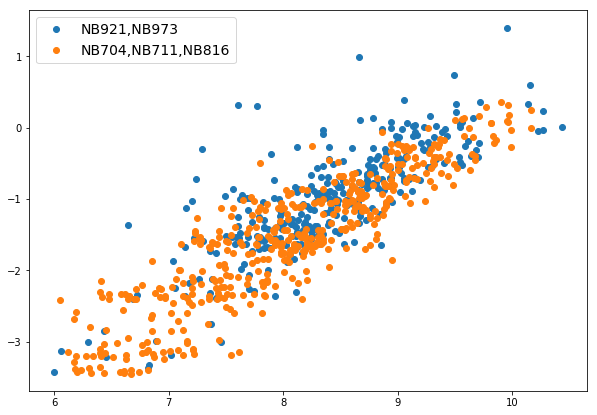

In [336]:
# [z_sp>0.3] is same as high_z = np.array([x for x in range(len(ffs)) if 'NB9' in ffs[x]])
plt.plot(mass[z_sp>0.3], sfrs[z_sp>0.3], 'o', label='NB921,NB973')
plt.plot(mass[z_sp<=0.3], sfrs[z_sp<=0.3], 'o', label='NB704,NB711,NB816')

plt.gcf().set_size_inches(10,7)
plt.legend(fontsize=14)

In [337]:
a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[],[]
# m_char_arr = np.arange(6.1,10.5,0.1)
# m_char_arr = np.arange(9.0,9.6,0.1)
m_char_arr = np.arange(8.0,10.1,0.1)
# m_char_arr = [9.2]

for m_char in m_char_arr:
    def piecewise_linear_z(x, a1, a2, b, c):
        m = x[:,0]
        z = x[:,1]
        return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])
    
    guesses = (0.9, 0.5, 2.8, -1.8)
    params, pcov = optimize.curve_fit(piecewise_linear_z, mz_data[z_sp>0.3], sfrs[z_sp>0.3], p0=guesses)
    a1 = params[0]
    a2 = params[1]
    b = params[2]
    c = params[3]
    
    resids = sfrs - piecewise_linear_z(mz_data, *params)
    print np.median(abs(resids)), np.mean(abs(resids))
    
    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    c_arr.append('%.2f'%c+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[3])
    
    rss = np.sum( (sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs[z_sp>0.3] - np.mean(sfrs[z_sp>0.3])) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (N - 1.0)/(N - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear_z(mz_data[z_sp>0.3], *params) - np.mean(sfrs[z_sp>0.3]))**2 )/np.std(sfrs[z_sp>0.3])**2
    chi2 = np.sum(((sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params))**2)/sigmas[z_sp>0.3]**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,4))
    chi2_arr.append(np.around(chi2,4))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b', 'c',
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

0.23361114415059991 0.3050299440038702
0.23840617570593192 0.3026574043049044
0.23627748175148344 0.29996945941311526
0.24086868835813768 0.29750684572027425
0.24078628744512476 0.29555309453227024
0.24241086954192204 0.29434832505604935
0.23828199852944154 0.29283286679408527
0.23825658240282355 0.2919472504641241
0.23494100131205276 0.2921048929403445
0.2366092048481101 0.29229796591635715
0.23524734064209474 0.29282711086533164
0.2340436527496612 0.2931133052717692
0.23314071064155484 0.2933239827188937
0.23192878554990176 0.2933860356655355
0.22910210199811787 0.29344158974190543
0.2288631538959911 0.29344903871806666
0.22879200821976786 0.2934797685395598
0.2293130731982389 0.29342822161786675
0.22958027267302927 0.29326642919580526
0.22895925603138045 0.29299486958574694
0.2280016531470911 0.2928627338214631


m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str13,str13,str13,str14,float64,float64,float64,float64,float64,float64,float64
8.0,0.11$\pm$0.09,0.68$\pm$0.04,4.75$\pm$0.34,-3.26$\pm$0.14,0.781471,0.780338,0.350455,253.1965,0.3276,92165.5612,119.231
8.1,0.15$\pm$0.08,0.70$\pm$0.04,4.71$\pm$0.33,-3.19$\pm$0.14,0.781336,0.780203,0.350563,253.1528,0.3275,93163.522,120.522
8.2,0.21$\pm$0.07,0.72$\pm$0.05,4.64$\pm$0.33,-3.11$\pm$0.14,0.779524,0.778382,0.352012,252.5659,0.3267,94286.6175,121.9749
8.299999999999999,0.27$\pm$0.07,0.73$\pm$0.05,4.54$\pm$0.33,-3.01$\pm$0.15,0.776533,0.775375,0.354392,251.5967,0.3255,95399.5986,123.4147
8.399999999999999,0.31$\pm$0.06,0.74$\pm$0.05,4.46$\pm$0.33,-2.91$\pm$0.15,0.774114,0.772943,0.356306,250.8128,0.3245,96512.6579,124.8547
8.499999999999998,0.35$\pm$0.06,0.76$\pm$0.06,4.40$\pm$0.33,-2.83$\pm$0.15,0.772722,0.771544,0.357402,250.3618,0.3239,97884.8151,126.6298
8.599999999999998,0.38$\pm$0.06,0.77$\pm$0.06,4.32$\pm$0.33,-2.73$\pm$0.15,0.770586,0.769397,0.359077,249.6698,0.323,99138.2732,128.2513
8.699999999999998,0.42$\pm$0.05,0.76$\pm$0.07,4.23$\pm$0.33,-2.63$\pm$0.15,0.768019,0.766817,0.361081,248.8381,0.3219,99679.0553,128.9509
8.799999999999997,0.45$\pm$0.05,0.76$\pm$0.08,4.16$\pm$0.33,-2.53$\pm$0.15,0.76576,0.764547,0.362834,248.1064,0.321,99338.79,128.5107


$$ f(x) = \begin{cases} 
      0 & x\leq 0 \\
      \frac{100-x}{100} & 0\leq x\leq 100 \\
      0 & 100\leq x 
   \end{cases}
$$